# Optional Lab - Softmax Function
In this lab, we will explore the softmax function. This function is used in both Softmax Regression and in Neural Networks when solving Multiclass Classification problems.  



  

In [ ]:
!pip install ipympl

In [64]:
from google.colab import output
output.enable_custom_widget_manager()  ## for visualization of graphs -- assuming the notebook is executed in google colab

In [65]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('./deeplearning.mplstyle')
from IPython.display import display, Markdown, Latex
from sklearn.datasets import make_blobs
%matplotlib widget
from matplotlib.widgets import Slider
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader


from lab_utils_common import dlc
from lab_utils_softmax import plt_softmax

> **Note**: Normally, in this course, the notebooks use the convention of starting counts with 0 and ending with N-1,  $\sum_{i=0}^{N-1}$, while lectures start with 1 and end with N,  $\sum_{i=1}^{N}$. This is because code will typically start iteration with 0 while in lecture, counting 1 to N leads to cleaner, more succinct equations. This notebook has more equations than is typical for a lab and thus  will break with the convention and will count 1 to N.

## Softmax Function
In both softmax regression and neural networks with Softmax outputs, N outputs are generated and one output is selected as the predicted category. In both cases a vector $\mathbf{z}$ is generated by a linear function which is applied to a softmax function. The softmax function converts $\mathbf{z}$  into a probability distribution as described below. After applying softmax, each output will be between 0 and 1 and the outputs will add to 1, so that they can be interpreted as probabilities. The larger inputs  will correspond to larger output probabilities.


The softmax function can be written:
$$a_j = \frac{e^{z_j}}{ \sum_{k=1}^{N}{e^{z_k} }} \tag{1}$$
The output $\mathbf{a}$ is a vector of length N, so for softmax regression, you could also write:
\begin{align}
\mathbf{a}(x) =
\begin{bmatrix}
P(y = 1 | \mathbf{x}; \mathbf{w},b) \\
\vdots \\
P(y = N | \mathbf{x}; \mathbf{w},b)
\end{bmatrix}
=
\frac{1}{ \sum_{k=1}^{N}{e^{z_k} }}
\begin{bmatrix}
e^{z_1} \\
\vdots \\
e^{z_{N}} \\
\end{bmatrix} \tag{2}
\end{align}


Which shows the output is a vector of probabilities. The first entry is the probability the input is the first category given the input $\mathbf{x}$ and parameters $\mathbf{w}$ and $\mathbf{b}$.  
Let's create a NumPy implementation:

In [66]:
def my_softmax(z):
    ez = np.exp(z)              #element-wise exponenial
    sm = ez/np.sum(ez)
    return(sm)

Below, vary the values of the `z` inputs using the sliders.

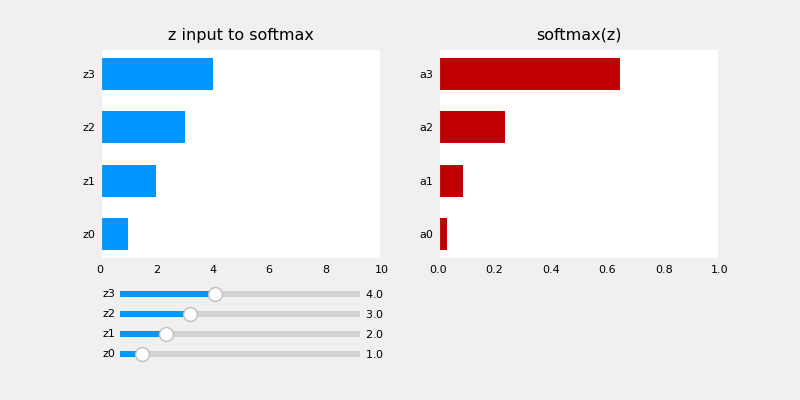

In [67]:
plt.close("all")
plt_softmax(my_softmax)

As you are varying the values of the z's above, there are a few things to note:
* the exponential in the numerator of the softmax magnifies small differences in the values
* the output values sum to one
* the softmax spans all of the outputs. A change in `z0` for example will change the values of `a0`-`a3`. Compare this to other activations such as ReLU or Sigmoid which have a single input and single output.

## Cost


The loss function associated with Softmax, the cross-entropy loss, is:
\begin{equation}
  L(\mathbf{a},y)=\begin{cases}
    -log(a_1), & \text{if $y=1$}.\\
        &\vdots\\
     -log(a_N), & \text{if $y=N$}
  \end{cases} \tag{3}
\end{equation}

Where y is the target category for this example and $\mathbf{a}$ is the output of a softmax function. In particular, the values in $\mathbf{a}$ are probabilities that sum to one.
>**Recall:** In this course, Loss is for one example while Cost covers all examples.


Note in (3) above, only the line that corresponds to the target contributes to the loss, other lines are zero. To write the cost equation we need an 'indicator function' that will be 1 when the index matches the target and zero otherwise.
    $$\mathbf{1}\{y == n\} = =\begin{cases}
    1, & \text{if $y==n$}.\\
    0, & \text{otherwise}.
  \end{cases}$$

Now the cost is:

\begin{align}
J(\mathbf{w},b) = -\frac{1}{m} \left[ \sum_{i=1}^{m} \sum_{j=1}^{N}  1\left\{y^{(i)} == j\right\} \log \frac{e^{z^{(i)}_j}}{\sum_{k=1}^N e^{z^{(i)}_k} }\right] \tag{4}
\end{align}

Where $m$ is the number of examples, $N$ is the number of outputs. This is the average of all the losses.


## PyTorch
This lab will *implement softmax with cross-entropy loss in PyTorch.*

In [81]:
# make  dataset for example
centers = [[-5, 2], [-2, -2], [1, 2], [5, -2]]
X_train, y_train = make_blobs(n_samples=2000, centers=centers, cluster_std=1.0,random_state=30)
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).long()

print(X_train.shape, y_train.shape)
print(type(X_train), type(y_train))

torch.Size([2000, 2]) torch.Size([2000])
<class 'torch.Tensor'> <class 'torch.Tensor'>


### Implementation

*There are two equally legit ways of implementing multiclass classification with CrossEntropy: either with the linear layer as the last activation layer  and CrossEntropyLoss as a criterion (aka loss function); or with LogSoftmax layer as the last activation layer and NNNLoss criterion. The former applies log-softmax internally. [Explanation from the forum](https://discuss.pytorch.org/t/difference-between-cross-entropy-loss-or-log-likelihood-loss/38816), [Cheetsheet](https://github.com/rasbt/stat479-deep-learning-ss19/blob/master/other/pytorch-lossfunc-cheatsheet.md)*.

*Here, I am using the linear layer as an activation function and CrossEntropyLoss*

In [90]:
class MulticlassClassifier(nn.Module):
    def __init__(self):
      super().__init__()

      self.training_accuracy = []
      self.training_loss = []

      self.linear1 = nn.Linear(in_features=2, out_features=25)
      self.relu1 = nn.ReLU()
      self.linear2 = nn.Linear(in_features=25, out_features=15)
      self.relu2 = nn.ReLU()
      self.linear3 = nn.Linear(in_features=15, out_features=4)

      if torch.cuda.is_available():   # Move the model to the GPU (if we have one)
        self.cuda()

    def forward(self, x):
      layer1_output = self.relu1(self.linear1(x))
      layer2_output = self.relu2(self.linear2(layer1_output))
      layer3_output = self.linear3(layer2_output)
      return layer3_output



*Initializing criterion (loss_fn) and optimizer for the classifier:*

In [91]:
loss_fn = nn.CrossEntropyLoss()
classifier = MulticlassClassifier()
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)

BATCH_SIZE = 32


*In order to process data in batches, let's use DataLoader class from PyTorch. But before, we need to customize Dataset class from PyTorch: in order to be able to iterate simultaneously over datapoints and labels.*

In [92]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = CustomDataset(X_train, y_train)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True  # Reshuffle the data at every epoch to reduce model overfitting
)


In [93]:
from tqdm import tqdm  # for printing ETA


def train_one_epoch(epoch):
    batch_loss = []

    # create wrapper around train_dataloader in order to see the progress in batches
    with tqdm(train_loader, total=len(X_train)//BATCH_SIZE+1, unit="batch", desc="Epoch %i" % epoch) as batches:
        for batch in batches:
          # unpack each batch into X and y
          inputs, labels = batch
          if torch.cuda.is_available():
            inputs = inputs.cuda()
            labels = labels.cuda()

          # Zero your gradients for every batch!
          optimizer.zero_grad()

          # Make predictions for this batch -- calling forward() internally
          outputs = classifier(inputs)

          # Compute the loss and its gradients
          loss = loss_fn(outputs, labels)
          loss.backward()

          # Adjust learning weights
          optimizer.step()

          # outputs.argmax picks one label with the highest value of logits and assigns it to the datapoint
          accuracy = (outputs.argmax(dim=1) == labels).float().mean().item() * 100

          classifier.training_accuracy.append(accuracy)
          classifier.training_loss.append(loss.item())

          batches.set_postfix(loss=loss.item(), accuracy=f'{accuracy}%')                  # Update the progress bar


In [94]:
EPOCHS = 10
for epoch in range(EPOCHS):
    train_one_epoch(epoch)

Epoch 9: 100%|██████████| 63/63 [00:00<00:00, 117.97batch/s, accuracy=100.0%, loss=0.00917]


*As we see, the training loss is decreasing while the training accuracy is growing with each epoch*.